In [13]:
import xgboost as xgb
import pickle
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import json
import seaborn as sns
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from helper import extract_data, create_features, sorted_correlations_with_gold, remove_correlated_features

In [15]:
with open("tickers.json", "r") as f:
    tickers = json.loads(f.read())

In [16]:
# load model
model = pickle.load(open("model/gold_price.pickle.dat", "rb"))

# load features
features_list = []

with open('features.txt', 'r') as f:
    for line in f:
        features_list.append(line[:-1])

In [4]:
n_days_ahead = 4

latest_date = (date.today()- timedelta(days=1))
end_date = latest_date.strftime("%Y-%m-%d")
start_date = (latest_date - timedelta(days=200)).strftime("%Y-%m-%d")
print("start_date: %s" %start_date)
print("end_date: %s" %end_date)
print("forecasting price of gold for %s" %(latest_date+ timedelta(days=n_days_ahead)).strftime("%Y-%m-%d"))

start_date: 2020-01-02
end_date: 2020-07-20
forecasting price of gold for 2020-07-24


In [5]:
infer_values = extract_data(start_date,end_date, tickers)
infer_values.tail()

,date,Gold,Silver,Crude Oil,S&P500,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100
196,2020-07-16,1807.1,19.67,40.76,3215.57,139.45,110.42,834.1,2.89,96.07,28.00,42.53,1.14,1008.60
197,2020-07-17,1812.1,19.75,40.57,3224.73,139.36,110.41,851.4,2.90,96.07,25.68,42.77,1.14,1006.22
198,2020-07-18,1812.1,19.75,40.57,3224.73,139.36,110.41,851.4,2.90,96.07,25.68,42.77,1.14,1006.22
199,2020-07-19,1810.3,19.74,40.63,3224.73,139.34,110.41,852.5,2.91,96.07,25.68,42.77,1.14,1006.22
200,2020-07-20,1810.3,19.74,40.63,3224.73,139.34,110.41,852.5,2.91,96.07,25.68,42.77,1.14,1006.22


In [6]:
features_list

['Gold_t-1',
 'Gold_t-7',
 'Gold_t-14',
 '10 Yr US T-Note futures_t-30',
 'Copper_t-2',
 'Euronext100_t-2',
 'Euronext100_t-3',
 'Volatility Index_t-21',
 '2 Yr US T-Note Futures_t-1',
 'MSCI EM ETF_t-2',
 'Silver_rocr_5',
 '10 Yr US T-Note futures_rocr_3',
 '10 Yr US T-Note futures_rocr_5',
 'Euronext100_rocr_14']

In [7]:
infer_features = create_features(infer_values)
infer_features = infer_features[['date']+features_list]
infer_features.tail()

,date,Gold_t-1,Gold_t-7,Gold_t-14,10 Yr US T-Note futures_t-30,Copper_t-2,Euronext100_t-2,Euronext100_t-3,Volatility Index_t-21,2 Yr US T-Note Futures_t-1,MSCI EM ETF_t-2,Silver_rocr_5,10 Yr US T-Note futures_rocr_3,10 Yr US T-Note futures_rocr_5,Euronext100_rocr_14
16,2020-07-16,-0.003694,-0.007415,0.015282,0.005190,-0.023649,0.011148,0.000625,-0.130975,0.000091,-0.011160,-0.215465,0.477849,-2.202526,-0.456163
17,2020-07-17,0.002767,0.004601,0.018091,0.006645,0.003460,-0.007046,0.008762,-0.260582,-0.000091,-0.008577,0.134425,-0.817008,-1.123629,-0.175497
18,2020-07-18,0.000000,0.004601,0.018091,0.005556,0.003460,-0.002360,-0.007046,-0.260582,0.000000,0.005643,0.000000,0.000000,0.000000,0.000000
19,2020-07-19,-0.000993,0.003214,0.012982,0.003674,0.003448,0.000000,-0.002360,-0.260582,0.000000,0.000000,-0.499241,0.181936,-0.222047,0.000000
20,2020-07-20,0.000000,0.004662,0.011341,0.003674,0.003448,0.000000,0.000000,-0.191945,0.000000,0.000000,-0.000000,-0.000000,-0.222047,-0.000000


In [8]:
output = model.predict(infer_features.iloc[:,1:])
df_predict = pd.DataFrame()
df_predict['date'] = infer_features['date']
df_predict['return_prediction'] = output


In [9]:
results = pd.DataFrame()
results['date']  = pd.date_range(start=infer_features['date'].iloc[0], end= infer_features['date'].iloc[-1] + timedelta(days=n_days_ahead))
results = pd.merge(left=results, right=infer_values[['date','Gold']], on='date', how='left')
results = pd.merge(left=results, right=df_predict[['date','return_prediction']], on='date', how='left')
results ['predicted_price'] = results['Gold']*(results ['return_prediction']+1)
results ['predicted_price'] = results ['predicted_price'].shift(n_days_ahead)
results.tail(10)

,date,Gold,return_prediction,predicted_price
15,2020-07-15,1813.8,0.000483,1804.703125
16,2020-07-16,1807.1,-0.001517,1805.461341
17,2020-07-17,1812.1,-0.000917,1802.869192
18,2020-07-18,1812.1,0.000501,1811.585103
19,2020-07-19,1810.3,0.000501,1814.676996
20,2020-07-20,1810.3,-0.000406,1804.358202
21,2020-07-21,NaN,NaN,1810.438381
22,2020-07-22,NaN,NaN,1813.007280
23,2020-07-23,NaN,NaN,1811.206379
24,2020-07-24,NaN,NaN,1809.564646


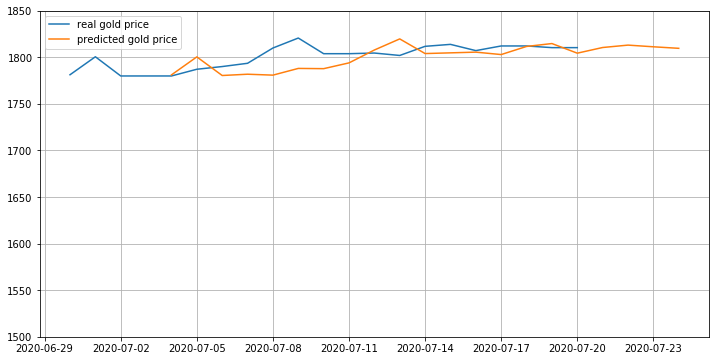

In [10]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['Gold'], label="real gold price")
plt.plot(results['date'], results['predicted_price'], label="predicted gold price")
plt.grid()
plt.ylim([1500,1850])
plt.legend()

In [11]:
prediction_date = '2020-07-24'

In [12]:
print("Predicted price for date %s: %2.2f" %(prediction_date,results[results['date']==prediction_date]['predicted_price'].values[0]))

Predicted price for date 2020-07-24: 1809.56
